<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

---
## Problem Statement

Maker Faire Conference wants to do a fun interactive app for their attendees at the upcoming conference. For the attendees who are fans of Arduinos and Raspberry Pi they want to build a classification model that will identify which person is a fan of either device based on the text they enter into the app. The goal of the model is to be as accurate as possible. The hope for this project is to delight the attendees and retain attendance for future conferences.

---

In [124]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [4]:
# read in subreddit data
subreddits = pd.read_csv('../data/subreddits.csv')
subreddits.head()

,subreddit,title,selftext
0,arduino,Can I use a usb bluetooth adapter on a Leonardo?,I have a little Beetle board that is a Leonard...
1,arduino,long shot but does anyone have a 3d model of t...,I want to build a 3d enclosure for this board ...
2,arduino,Need help understanding some variables and fun...,I need to understand the code from [this](http...
3,arduino,A picture book teaches C programming basics,"When I was learning C programming, I found tha..."
4,arduino,How to trick an airbag controller,"Not exactly Arduino related, but hopefully som..."


# Exploratory Data Analysis

## Pre-Processing

In [29]:
# transform subreddit class into 0 and 1s
subreddits['sub_label'] = subreddits['subreddit'].map({'arduino': 0, 'raspberry_pi': 1})

# Combine subreddit title and selftext to easily pass through vectorizer
subreddits['post_text'] = subreddits['title'] + subreddits['selftext']

In [96]:
subreddits['post_length'] = subreddits['post_text'].apply(len)
subreddits['post_word_count'] = subreddits['post_text'].apply(lambda x: len(x.split()))

In [97]:
subreddits.describe()

,sub_label,post_length,post_word_count
count,5176.000000,5176.000000,5176.000000
mean,0.519513,921.503091,140.597372
std,0.499667,1443.334535,180.468613
min,0.000000,2.000000,1.000000
25%,0.000000,364.000000,63.000000
50%,1.000000,566.500000,96.000000
75%,1.000000,927.000000,153.000000
max,1.000000,32282.000000,3634.000000


In [98]:
arduino = subreddits[subreddits['subreddit'] == 'arduino']
raspberrypi = subreddits[subreddits['subreddit'] == 'raspberry_pi']

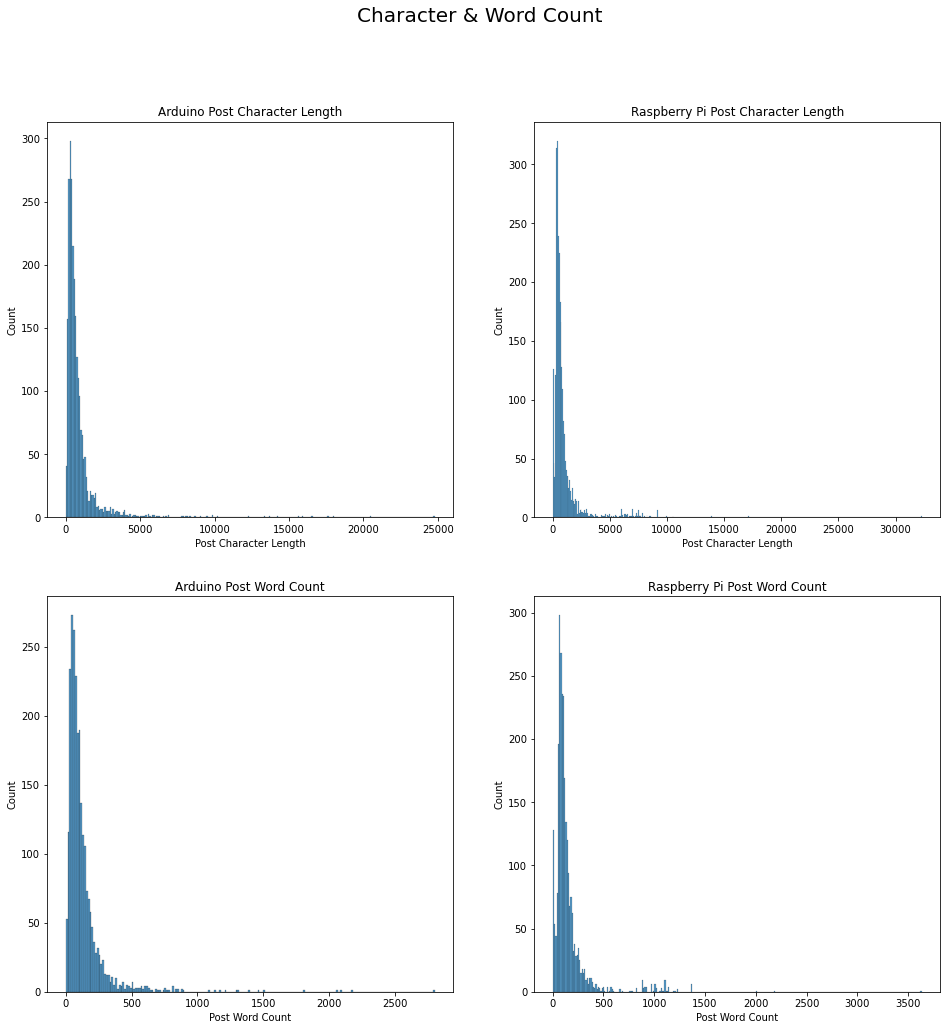

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
sns.histplot(arduino['post_length'], ax=ax[0,0])
sns.histplot(raspberrypi['post_length'], ax=ax[0,1])
sns.histplot(arduino['post_word_count'], ax=ax[1,0])
sns.histplot(raspberrypi['post_word_count'], ax=ax[1,1])

ax[0,0].set(xlabel='Post Character Length', title='Arduino Post Character Length')
ax[0,1].set(xlabel='Post Character Length', title='Raspberry Pi Post Character Length')
ax[1,0].set(xlabel='Post Word Count', title='Arduino Post Word Count')
ax[1,1].set(xlabel='Post Word Count', title='Raspberry Pi Post Word Count')

fig.suptitle('Character & Word Count', fontsize=20);

It appears that both Arduino and Raspberry Pi subreddits have roughly the same distribution for post character counts, with Raspberry Pi having a slightly higher mean count. Raspberry Pi subreddit has slightly longer posts compared to the Arduino subreddit.

In [122]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words='english')

# Fit cvec on subreddit corpus and convert to dataframe
arduino_vec = cvec.fit_transform(arduino['post_text'])
arduino_vec_df = pd.DataFrame(arduino_vec.todense(), columns=cvec.get_feature_names())

raspberrypi_vec = cvec.fit_transform(raspberrypi['post_text'])
raspberrypi_vec_df = pd.DataFrame(raspberrypi_vec.todense(), columns=cvec.get_feature_names())

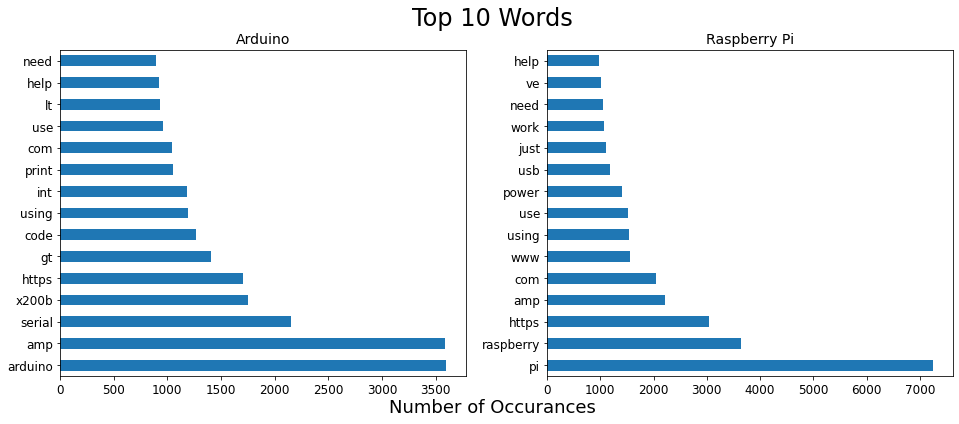

In [123]:
# plot top occurring words
fig, ax = plt.subplots(1, 2, figsize=(16,6))
arduino_vec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], fontsize=12)
raspberrypi_vec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1], fontsize=12)

ax[0].set_title('Arduino', fontsize=14)
ax[1].set_title('Raspberry Pi', fontsize=14)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', ha='center', fontsize=18);

Arduino and amp are the most common words appearing more than 3500 times across the posts in the Arduino subreddit. rapberry and pi are the most common words in the Raspberry pi subreddits. There are some similaries across both subreddits such as: help, need, https, but there seems to be enough differences between the most common words.

# Modeling with CountVectorizer

## Random Forest Modeling

In [94]:
# Feature
X = subreddits['post_text']
# Target
y = subreddits['sub_label']

# Train/Test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33, 
                                                    stratify=y, 
                                                    random_state=42)

In [31]:
# Baseline accuracy --> 52%
y.value_counts(normalize=True)

1    0.519513
0    0.480487
Name: sub_label, dtype: float64

In [72]:
%%time
# Create pipeline
rfpipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])

# Setup pipe parameters
pipe_params = {
    'cvec__max_features': [2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.90, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 3],
    'rf__max_features': ['sqrt', 0.50]
    
}

# Instantiate GridSearch with pipe and parameters
gs = GridSearchCV(rfpipe, pipe_params, cv = 5, n_jobs = -1, verbose = 1)

# Fit grid search model with train data
gs.fit(X_train, y_train)

# Print best score from best model
print(gs.best_score_)

# Print parameters from best model
gs.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.9538509841103501
CPU times: user 6.58 s, sys: 1.1 s, total: 7.68 s
Wall time: 18min 3s


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 100}

In [73]:
# score train data
gs.score(X_train, y_train)

1.0

In [74]:
# score test data
gs.score(X_test, y_test)

0.9607957870099474

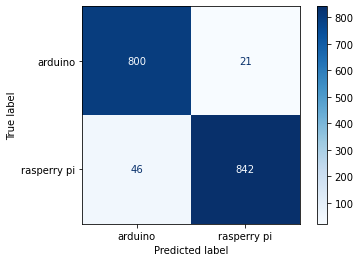

In [81]:
# Plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, display_labels=['arduino', 'rasperry pi'], cmap='Blues');

The Random Forest model is overfitting on the train data, but even with that, the model has about a 96.08% accuracy rate at predicting subreddits. Out of all the data in the test set the model produced 67 errors.

## KNN Modeling

In [82]:
%%time

# create pipeline
knnpipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

# setup pipe parameters
pipe_params = {
    'cvec__max_features': [2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.90, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'knn__p': [1,2],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5]
}

# Instantiate GridSearch with pipe and parameters
gs = GridSearchCV(knnpipe, pipe_params, cv = 5, n_jobs = -1, verbose = 1)

# Fit grid search model with train data
gs.fit(X_train, y_train)

# Print best score from best model
print(gs.best_score_)

# Print parameters from best model
gs.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.8142545254937186
CPU times: user 6.08 s, sys: 1.02 s, total: 7.1 s
Wall time: 7min 27s


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'distance'}

In [83]:
# score train data
gs.score(X_train, y_train)

0.9994231323911162

In [84]:
# score test data
gs.score(X_test, y_test)

0.8385020479812756

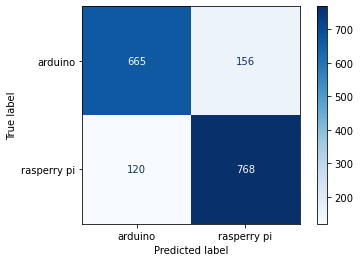

In [85]:
# Plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, display_labels=['arduino', 'rasperry pi'], cmap='Blues');

The KNN model is also overfitting on the train data. This model in comparision to the Random Forest model performed significantly worse. The KNN model has about an 83.85% accuracy rate. This model out of all the test data had 276 errors; that's 209 more errors than the Random Forest Model.

# Modeling with TF-IDF Vectorizer

## Random Forest Modeling

In [86]:
%%time
# Create pipeline
rfpipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])

# Setup pipe parameters
pipe_params = {
    'tvec__max_features': [2000, 3000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.90, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 3],
    'rf__max_features': ['sqrt', 0.50]
    
}

# Instantiate GridSearch with pipe and parameters
gs = GridSearchCV(rfpipe, pipe_params, cv = 5, n_jobs = -1, verbose = 1)

# Fit grid search model with train data
gs.fit(X_train, y_train)

# Print best score from best model
print(gs.best_score_)

# Print parameters from best model
gs.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.9526953354042691
CPU times: user 6.8 s, sys: 1 s, total: 7.8 s
Wall time: 23min 40s


{'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 100,
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

In [87]:
# score train data
gs.score(X_train, y_train)

1.0

In [88]:
# score test data
gs.score(X_test, y_test)

0.96255119953189

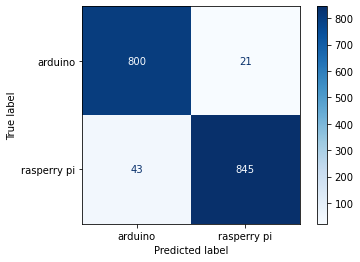

In [89]:
# Plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, display_labels=['arduino', 'rasperry pi'], cmap='Blues');

The Random Forest model is also overfitting on the training data. This model performed well, with a 96.26% accuracy rate at prediciting subreddits. This model on the test data had a total of 64 errors.

## KNN Modeling

In [90]:
%%time

# create pipeline
knnpipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

# setup pipe parameters
pipe_params = {
    'tvec__max_features': [2000, 3000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.90, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'knn__p': [1,2],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5]
}

# Instantiate GridSearch with pipe and parameters
gs = GridSearchCV(knnpipe, pipe_params, cv = 5, n_jobs = -1, verbose = 1)

# Fit grid search model with train data
gs.fit(X_train, y_train)

# Print best score from best model
print(gs.best_score_)

# Print parameters from best model
gs.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.8416445226243496
CPU times: user 6.9 s, sys: 6.71 s, total: 13.6 s
Wall time: 8min 55s


{'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'distance',
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [91]:
# score train data
gs.score(X_train, y_train)

1.0

In [92]:
# score test data
gs.score(X_test, y_test)

0.8379169104739613

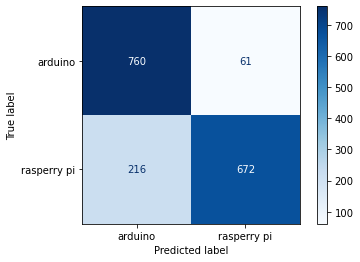

In [93]:
# Plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, display_labels=['arduino', 'rasperry pi'], cmap='Blues');

The KNN model also overfit on the test data. It's more overfit than the previous KNN model. It scored slightly worse than the previous KNN model with an 83.80% accuracy rate. This model also performed the worse out of all the previous 3 models. This KNN model on the test data had 277 errors.

# Recommendations

Overall the two Random Forest models performed the best out of all 4 models. The Random Forest model using the TF-IDF Vectorizer performed slightly better out of the two models. With the goal of accuracy in mind, I recommend using this model as the production model. It had an accuracy of 96.25% and made only 64 errors on the test set.

Some potential models to explore for improving the accuracy rating would be to try other ensemble models such as AdaBoost, Gradient Boost, or XGBoost. Testing these three models against our best Random Forest Model could potentially produce better accuracy scores at prediciting subreddits.